In [158]:
# clearance: this import header is copied from:
# https://www.kaggle.com/ludovicocuoghi/detecting-bullying-tweets-w-pytorch-bi-lstm/notebook
#
# some of the code concerning data manipulation, model fitting and matplotlib usage are modified
# from online open-sources, please refer to refrence section in original report for details.
#
# All the core codes including Experiments design and evaluations are completely ORIGINAL.


#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from random import sample
from wordcloud import WordCloud

#Text cleaning
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample
from sklearn.decomposition import PCA


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


#Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance


In [159]:
df = pd.read_csv("../data/philosophy_data.csv")
df.head()

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360808 entries, 0 to 360807
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   title                      360808 non-null  object
 1   author                     360808 non-null  object
 2   school                     360808 non-null  object
 3   sentence_spacy             360808 non-null  object
 4   sentence_str               360808 non-null  object
 5   original_publication_date  360808 non-null  int64 
 6   corpus_edition_date        360808 non-null  int64 
 7   sentence_length            360808 non-null  int64 
 8   sentence_lowered           360808 non-null  object
 9   tokenized_txt              360808 non-null  object
 10  lemmatized_str             360808 non-null  object
dtypes: int64(3), object(8)
memory usage: 30.3+ MB


In [161]:
school_list = df.school.unique()
school2idx = {}
for school in school_list:
    school2idx[school] = len(school2idx)
school2idx

{'plato': 0,
 'aristotle': 1,
 'empiricism': 2,
 'rationalism': 3,
 'analytic': 4,
 'continental': 5,
 'phenomenology': 6,
 'german_idealism': 7,
 'communism': 8,
 'capitalism': 9,
 'stoicism': 10,
 'nietzsche': 11,
 'feminism': 12}

In [162]:
X = df['tokenized_txt']
y = np.array([school2idx[i] for i in df['school']]).reshape(-1,)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [163]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 27624],
       [    1, 35121],
       [    2, 14350],
       [    3, 16523],
       [    4, 39906],
       [    5, 24321],
       [    6, 20572],
       [    7, 30338],
       [    8, 12929],
       [    9, 13100],
       [   10,  1825],
       [   11,  9755],
       [   12, 13417]])

In [164]:
def build_vocabulary(column):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in eval(text)]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()

    return sorted_words

In [165]:
vocab = build_vocabulary(df['tokenized_txt'])

In [166]:
vocab = [i[0] for i in vocab]

In [167]:
vocab[:10]

['the', 'of', 'and', 'to', 'is', 'in', 'that', 'it', 'as', 'be']

In [168]:
def extract_tfidf(train_data, vocabulary = None, test_data = None):
    if vocabulary is not None:
        clf = CountVectorizer(vocabulary = vocabulary)
    else:
        clf = CountVectorizer()
    train_cv =  clf.fit_transform(train_data)
    if test_data is not None:
        test_cv = clf.transform(test_data)
    tf_transformer = TfidfTransformer(use_idf=True).fit(train_cv)
    train_tf = tf_transformer.transform(train_cv)
    if test_data is not None:
        test_tf = tf_transformer.transform(test_cv)
    else:
        test_tf = None
    return train_tf, test_tf

In [169]:
X_train_tf, X_test_tf = extract_tfidf(X_train, test_data = X_test)

In [170]:
nb_clf_full = MultinomialNB()
nb_clf_full.fit(X_train_tf, y_train)
nb_pred = nb_clf_full.predict(X_test_tf)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=school_list))

Classification Report for Naive Bayes:
                  precision    recall  f1-score   support

          plato       0.63      0.71      0.67      7673
      aristotle       0.55      0.87      0.67      9756
     empiricism       0.90      0.40      0.55      3986
    rationalism       0.86      0.38      0.53      4590
       analytic       0.59      0.89      0.71     11085
    continental       0.77      0.67      0.71      6756
  phenomenology       0.92      0.48      0.63      5715
german_idealism       0.66      0.83      0.74      8427
      communism       0.93      0.52      0.67      3592
     capitalism       0.86      0.75      0.80      3639
       stoicism       0.00      0.00      0.00       507
      nietzsche       0.87      0.24      0.38      2709
       feminism       0.93      0.49      0.65      3727

       accuracy                           0.67     72162
      macro avg       0.73      0.56      0.59     72162
   weighted avg       0.73      0.67      0.66

/Users/jake/opt/anaconda3/envs/eods-s22/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jake/opt/anaconda3/envs/eods-s22/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jake/opt/anaconda3/envs/eods-s22/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

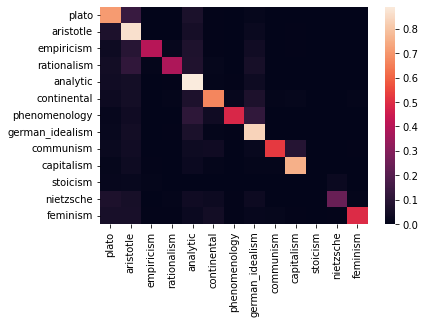

In [171]:
cm = confusion_matrix(y_test,nb_pred)
cm = cm / cm.astype(np.float32).sum(axis=1)
df_cm = pd.DataFrame(cm, index = [i for i in school_list],
                  columns = [i for i in school_list])
sns.heatmap(df_cm, annot=False)
plt.savefig("../figs/cm_nb_baseline.jpeg")

In [172]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['tokenized_txt', 'school'])
X_train = train_os['tokenized_txt'].values
y_train = train_os['school'].values
X_train_tf, X_test_tf = extract_tfidf(X_train, test_data=X_test)

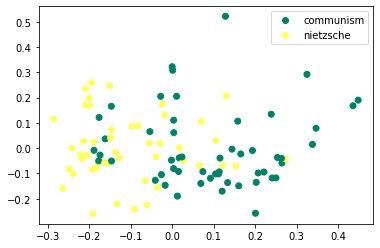

In [173]:
vis_os = train_os[train_os['school'].isin([8, 11])]
df_vis = resample(vis_os, 
                 replace=True,
                 n_samples=100, random_state= 9)
X_vis = df_vis['tokenized_txt'].values
y_vis = df_vis['school'].values
X_vis = extract_tfidf(X_vis)[0].todense()
pca = PCA(n_components=3)
X_vis = pca.fit_transform(X_vis)
ax  = plt.subplot()
d_temp = {8:  "communism", 11: "nietzsche"}
scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], cmap = 'summer', c = y_vis)
ax.legend(handles=scatter.legend_elements()[0], labels = ["communism", "nietzsche"])
plt.savefig("../figs/PCA_dicho.jpeg")

In [174]:
nb_clf_balanced = MultinomialNB()
nb_clf_balanced.fit(X_train_tf, y_train)
nb_pred = nb_clf_balanced.predict(X_test_tf)

Classification Report for Naive Bayes:
                  precision    recall  f1-score   support

          plato       0.71      0.75      0.73      7673
      aristotle       0.80      0.74      0.77      9756
     empiricism       0.58      0.83      0.68      3986
    rationalism       0.66      0.72      0.69      4590
       analytic       0.86      0.72      0.78     11085
    continental       0.83      0.71      0.76      6756
  phenomenology       0.77      0.72      0.75      5715
german_idealism       0.79      0.80      0.80      8427
      communism       0.77      0.75      0.76      3592
     capitalism       0.75      0.88      0.81      3639
       stoicism       0.32      0.80      0.46       507
      nietzsche       0.67      0.69      0.68      2709
       feminism       0.74      0.76      0.75      3727

       accuracy                           0.75     72162
      macro avg       0.71      0.76      0.72     72162
   weighted avg       0.76      0.75      0.75

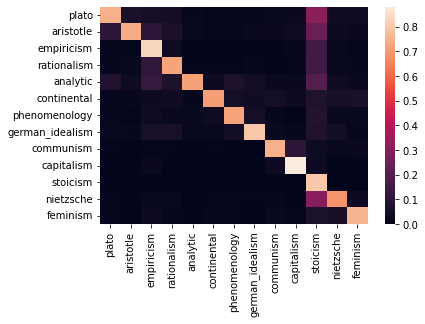

In [175]:
cm = confusion_matrix(y_test,nb_pred)
cm = cm / cm.astype(np.float32).sum(axis=1)
df_cm = pd.DataFrame(cm, index = [i for i in school_list],
                  columns = [i for i in school_list])
sns.heatmap(df_cm, annot=False)
plt.savefig("../figs/cm_nb_balanced.jpeg")
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=school_list))

In [176]:
def draw_wordcloud_importance(model, vocab):
    nclass = model.coef_.shape[0]
    for i in range(nclass):
        t = model.coef_[i].argsort()[::-1]
        word_idx_list = t[:20]
        likelihood = np.exp(model.feature_log_prob_[i][word_idx_list])
        likelihood /= sum(likelihood)
        d = {w: f for w, f in
             zip([vocab[i] for i in word_idx_list], likelihood)}
        wordcloud = WordCloud()
        wordcloud.generate_from_frequencies(frequencies=d)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.savefig("../figs/word_importance_{}.jpeg".format(school_list[i]))
        plt.show()

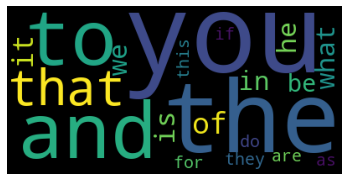

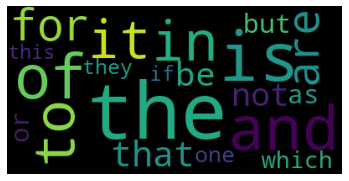

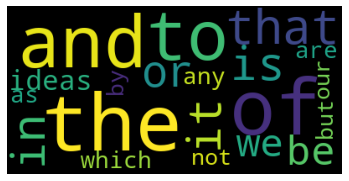

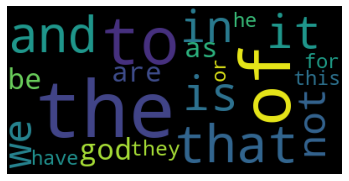

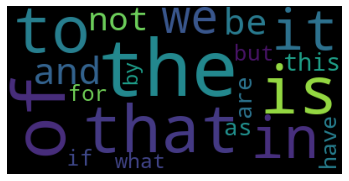

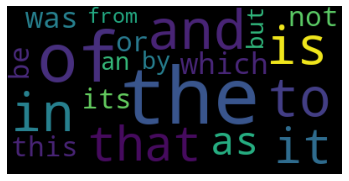

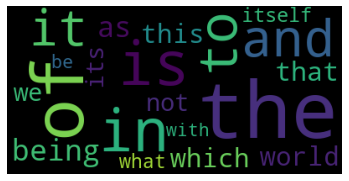

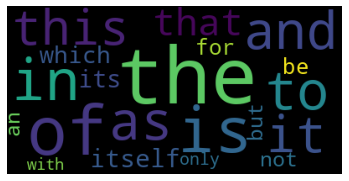

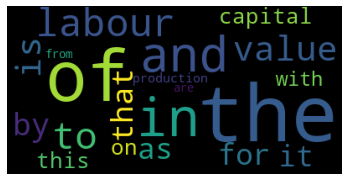

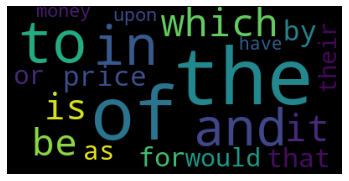

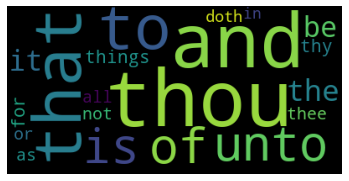

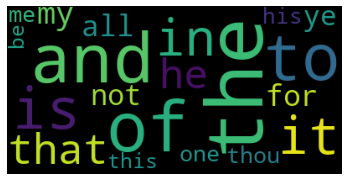

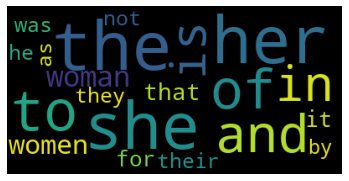

In [178]:
clf = CountVectorizer()
clf.fit(X_train)
draw_wordcloud_importance(nb_clf_full, clf.get_feature_names())

In [184]:
new_vocab = set()
nclass = nb_clf_full.coef_.shape[0]
word_list = clf.get_feature_names()
for i in range(nclass):
    t = nb_clf_full.coef_[i].argsort()[::-1]
    word_idx_list = t[:200]
    for i in word_idx_list:
        new_vocab.add(word_list[i])
new_vocab = list(new_vocab)

/Users/jake/opt/anaconda3/envs/eods-s22/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [185]:
X = df['tokenized_txt']
y = np.array([school2idx[i] for i in df['school']]).reshape(-1,)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [186]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['tokenized_txt', 'school'])
X_train = train_os['tokenized_txt'].values
y_train = train_os['school'].values
X_train_tf, X_test_tf = extract_tfidf(X_train, new_vocab,X_test)

In [187]:
nb_clf_exp = MultinomialNB()
nb_clf_exp.fit(X_train_tf, y_train)
nb_pred = nb_clf_exp.predict(X_test_tf)

Classification Report for Naive Bayes:
                  precision    recall  f1-score   support

          plato       0.54      0.59      0.56      7673
      aristotle       0.60      0.55      0.58      9756
     empiricism       0.47      0.57      0.51      3986
    rationalism       0.43      0.48      0.45      4590
       analytic       0.65      0.49      0.56     11085
    continental       0.58      0.44      0.50      6756
  phenomenology       0.53      0.54      0.53      5715
german_idealism       0.65      0.63      0.64      8427
      communism       0.57      0.60      0.58      3592
     capitalism       0.63      0.75      0.69      3639
       stoicism       0.19      0.68      0.29       507
      nietzsche       0.37      0.46      0.41      2709
       feminism       0.60      0.63      0.62      3727

       accuracy                           0.55     72162
      macro avg       0.52      0.57      0.53     72162
   weighted avg       0.57      0.55      0.56

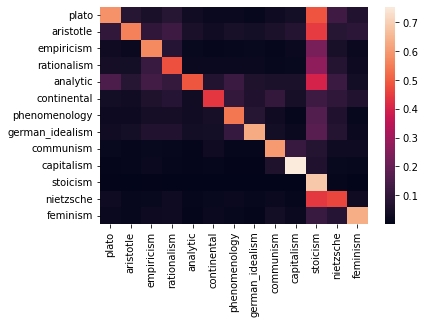

In [188]:
cm = confusion_matrix(y_test,nb_pred)
cm = cm / cm.astype(np.float32).sum(axis=1)
df_cm = pd.DataFrame(cm, index = [i for i in school_list],
                  columns = [i for i in school_list])
sns.heatmap(df_cm, annot=False)
plt.savefig("../figs/cm_nb_ld.jpeg")

print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=school_list))

Classification Report for Naive Bayes:
                  precision    recall  f1-score   support

          plato       0.53      0.54      0.53      7673
      aristotle       0.61      0.52      0.56      9756
     empiricism       0.47      0.55      0.51      3986
    rationalism       0.43      0.46      0.44      4590
       analytic       0.65      0.48      0.55     11085
    continental       0.53      0.40      0.45      6756
  phenomenology       0.52      0.53      0.53      5715
german_idealism       0.66      0.61      0.64      8427
      communism       0.45      0.52      0.48      3592
     capitalism       0.54      0.70      0.61      3639
       stoicism       0.12      0.67      0.21       507
      nietzsche       0.29      0.43      0.35      2709
       feminism       0.59      0.60      0.59      3727

       accuracy                           0.52     72162
      macro avg       0.49      0.54      0.50     72162
   weighted avg       0.55      0.52      0.53

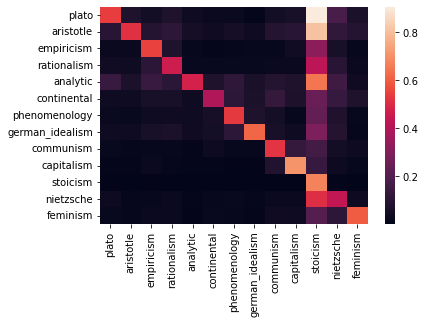

In [189]:
X_train_tf, X_test_tf = extract_tfidf(X_train, vocab[:len(new_vocab)] ,X_test)
nb_clf_baseline = MultinomialNB()
nb_clf_baseline.fit(X_train_tf, y_train)
nb_pred = nb_clf_baseline.predict(X_test_tf)
cm = confusion_matrix(y_test,nb_pred)
cm = cm / cm.astype(np.float32).sum(axis=1)
df_cm = pd.DataFrame(cm, index = [i for i in school_list],
                  columns = [i for i in school_list])
sns.heatmap(df_cm, annot=False)
plt.savefig("../figs/cm_nb_bl.jpeg")
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=school_list))

In [190]:
test_df = pd.read_csv("../data/trump_quote.csv")

In [191]:
X_test = test_df['raw_data'].values
X_test = np.array([i.lower() for i in X_test])

In [192]:
def get_tfidf(test_data, clf, tf_transformer):
    test_cv = clf.transform(test_data)
    test_tf = tf_transformer.transform(test_cv)
    return test_tf

In [193]:
clf = CountVectorizer()
clf.fit(X_train)
tf_transformer = TfidfTransformer(use_idf=True).fit(train_cv)
X_test_tf = get_tfidf(X_test, clf ,tf_transformer)

In [194]:
nb_pred = nb_clf_full.predict(X_test_tf)

In [195]:
for pred, sentence in zip(nb_pred, X_test):
    print(sentence)
    print(school_list[pred])
    print()

i deal with foreign countries. i made a lot of money dealing against china. i've made a lot of money dealing against many other countries.
plato

with the coldest winter ever recorded, with snow setting record levels up and down the coast, the nobel committee should take the nobel prize back from al gore
aristotle

i don't like to sit back and gloat, because the world is fragile. life is fragile, so i never really gloat.
analytic

this very expensive global warming bullshit has got to stop. our planet is freezing, record low temps,and our gw scientists are stuck in ice.
analytic

a lot of people want me to run for things, for a lot of high offices. the polls always show that i win any election that i'm in. but i don't have any real interest in running for office. i'm more interested in supporting people. 
plato

